In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from loguru import logger

In [2]:
df = pd.read_csv("stockton.csv")    
df.columns   

Index(['price', 'livarea', 'beds', 'baths', 'lgelot', 'age', 'pool'], dtype='object')

### (a) Histogram of PRICE and ln(PRICE)

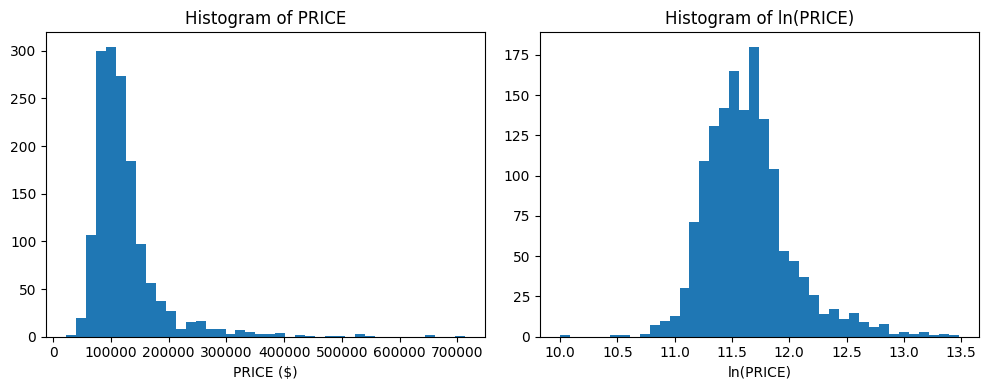

In [3]:
df['ln_price'] = np.log(df['price'])
df['ln_price_k'] = np.log(df['price'] / 1000)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['price'], bins=40)
plt.title("Histogram of PRICE")
plt.xlabel("PRICE ($)")

plt.subplot(1,2,2)
plt.hist(df['ln_price'], bins=40)
plt.title("Histogram of ln(PRICE)")
plt.xlabel("ln(PRICE)")
plt.tight_layout()
plt.show()

### (b) Regression of ln(PRICE/1000) on predictors

In [4]:
model_b = smf.ols("ln_price_k ~ livarea + beds + baths + lgelot + age + pool", data=df)
res_b = model_b.fit(cov_type="HC1")
logger.info("=== Part (b) Results ===")
logger.success(res_b.summary())

2025-09-17 23:20:10.368 | INFO     | __main__:<module>:3 - === Part (b) Results ===
2025-09-17 23:20:10.377 | SUCCESS  | __main__:<module>:4 -                             OLS Regression Results                            
Dep. Variable:             ln_price_k   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     290.6
Date:                Wed, 17 Sep 2025   Prob (F-statistic):          1.15e-246
Time:                        23:20:10   Log-Likelihood:                 196.13
No. Observations:                1500   AIC:                            -378.3
Df Residuals:                    1493   BIC:                            -341.1
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025 

### (c) Effect of large lot size

In [5]:
beta_l = res_b.params['lgelot']
se_l = res_b.bse['lgelot']
pct = 100*(np.exp(beta_l)-1)
ci_low = 100*(np.exp(beta_l - 1.96*se_l)-1)
ci_high = 100*(np.exp(beta_l + 1.96*se_l)-1)
logger.info("\n=== Part (c) Large Lot Effect ===")
logger.success(f"LGELOT coefficient = {beta_l:.4f}")
logger.debug(f"Interpretation: Large lot adds about {pct:.2f}% to price (95% CI: {ci_low:.2f}%, {ci_high:.2f}%).")

2025-09-17 23:20:10.393 | INFO     | __main__:<module>:6 - 
=== Part (c) Large Lot Effect ===
2025-09-17 23:20:10.394 | SUCCESS  | __main__:<module>:7 - LGELOT coefficient = 0.2531
2025-09-17 23:20:10.395 | DEBUG    | __main__:<module>:8 - Interpretation: Large lot adds about 28.80% to price (95% CI: 20.93%, 37.18%).


### (d) Interaction LGELOT * LIVAREA

In [6]:
model_d = smf.ols("ln_price_k ~ livarea + beds + baths + lgelot + age + pool + lgelot:livarea", data=df)
res_d = model_d.fit(cov_type="HC1")
logger.info("\n=== Part (d) Results ===")
logger.success(res_d.summary())

2025-09-17 23:20:10.429 | INFO     | __main__:<module>:3 - 
=== Part (d) Results ===
2025-09-17 23:20:10.437 | SUCCESS  | __main__:<module>:4 -                             OLS Regression Results                            
Dep. Variable:             ln_price_k   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     334.0
Date:                Wed, 17 Sep 2025   Prob (F-statistic):          5.21e-300
Time:                        23:20:10   Log-Likelihood:                 215.31
No. Observations:                1500   AIC:                            -414.6
Df Residuals:                    1492   BIC:                            -372.1
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0

### (e) Joint hypothesis test: beds & baths

In [7]:
f_test_e = res_b.f_test("beds = 0, baths = 0")
logger.info("\n=== Part (e) F-test for BEDS and BATHS ===")
logger.success(f_test_e)

2025-09-17 23:20:10.451 | INFO     | __main__:<module>:2 - 
=== Part (e) F-test for BEDS and BATHS ===
2025-09-17 23:20:10.452 | SUCCESS  | __main__:<module>:3 - <F test: F=4.6818211639873955, p=0.009398541305379792, df_denom=1.49e+03, df_num=2>


### (f) Drop baths and re-estimate

In [8]:
model_f = smf.ols("ln_price_k ~ livarea + beds + lgelot + age + pool", data=df)
res_f = model_f.fit(cov_type="HC1")
logger.info("\n=== Part (f) Results ===")
logger.success(res_f.summary())

2025-09-17 23:20:10.475 | INFO     | __main__:<module>:3 - 
=== Part (f) Results ===
2025-09-17 23:20:10.481 | SUCCESS  | __main__:<module>:4 -                             OLS Regression Results                            
Dep. Variable:             ln_price_k   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     335.9
Date:                Wed, 17 Sep 2025   Prob (F-statistic):          2.30e-241
Time:                        23:20:10   Log-Likelihood:                 195.94
No. Observations:                1500   AIC:                            -379.9
Df Residuals:                    1494   BIC:                            -348.0
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025

In [9]:
logger.info("\nPool effect comparison:")
logger.debug(f"With baths: {res_b.params['pool']:.4f}")
logger.error(f"Without baths: {res_f.params['pool']:.4f}")

2025-09-17 23:20:10.497 | INFO     | __main__:<module>:1 - 
Pool effect comparison:
2025-09-17 23:20:10.499 | DEBUG    | __main__:<module>:2 - With baths: 0.0787
2025-09-17 23:20:10.500 | ERROR    | __main__:<module>:3 - Without baths: 0.0782


### (g) Transform AGE to categories

In [10]:
bins = [-1, 10, 20, 40, 1e9]
labels = ['0_10', '11_20', '21_40', '41_plus']
df['age_cat'] = pd.cut(df['age'], bins=bins, labels=labels)

age_dummies = pd.get_dummies(df['age_cat'], prefix='age', drop_first=True)
df = pd.concat([df, age_dummies], axis=1)

model_g = smf.ols("ln_price_k ~ livarea + beds + baths + lgelot + pool + age_11_20 + age_21_40 + age_41_plus", data=df)
res_g = model_g.fit(cov_type="HC1")
logger.info("\n=== Part (g) Results ===")
logger.success(res_g.summary())

2025-09-17 23:20:10.531 | INFO     | __main__:<module>:10 - 
=== Part (g) Results ===
2025-09-17 23:20:10.538 | SUCCESS  | __main__:<module>:11 -                             OLS Regression Results                            
Dep. Variable:             ln_price_k   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     222.3
Date:                Wed, 17 Sep 2025   Prob (F-statistic):          6.57e-248
Time:                        23:20:10   Log-Likelihood:                 219.24
No. Observations:                1500   AIC:                            -420.5
Df Residuals:                    1491   BIC:                            -372.7
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z| 